### **This notebook involves the Sentiment analysis of Restaraunt reviews using scraped dataset.**

Install required libraries

In [ ]:
!pip install scikit-plot
!pip install transformers

     |████████████████████████████████| 2.3MB 25.8MB/s 
     |████████████████████████████████| 901kB 38.5MB/s 
     |████████████████████████████████| 3.3MB 48.4MB/s 


Import required libraries

In [ ]:
#Import required libraries
import time 
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve,auc

import scikitplot as skplt

import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader,TensorDataset, RandomSampler, SequentialSampler
import torch.nn as nn  
import torch.nn.functional as F  
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu');

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 12,6

import warnings
warnings.filterwarnings('ignore')

seed=42
np.random.seed(seed)
torch.manual_seed(seed)

import pickle

import warnings 
warnings.filterwarnings('ignore')

Load the data

In [ ]:
df = pd.read_csv('sentiment_analysis.csv')
df = df.drop('Unnamed: 0',axis=1)
df.head()

,Title,ReviewDate,Stay Date,comments,Restaurant_Name,Review_Sentiment
0,b'Highly recommended',"b'Reviewed September 14, 2020 '",b'Date of visit: September 2020',[b'We went for Lunch. From very first their pa...,The Four Leafed Clover,POSITIVE
1,"b'Excellent food, great ambience'","b'Reviewed September 5, 2020 '",b'Date of visit: September 2020',[b'Great service and delicious food. We had th...,The Four Leafed Clover,POSITIVE
2,b'Excellent Food and Place',"b'Reviewed August 15, 2020 '",b'Date of visit: August 2020',"[b'As I went, there were enough parking space,...",The Four Leafed Clover,POSITIVE
3,b'Good Food and Ambience\n\n Food',"b'Reviewed February 9, 2020 '",b'Date of visit: February 2020',[b'Good Food and Ambience\n\n Food and ambienc...,The Four Leafed Clover,POSITIVE
4,b'Loved everything about The Four Leafed Clover',"b'Reviewed January 17, 2020 '",b'Date of visit: January 2020',"[b""Excellent quiet and clean place for a relax...",The Four Leafed Clover,POSITIVE


In [ ]:
#Check columns
df.columns

Index(['Title', 'ReviewDate', 'Stay Date', 'comments', 'Restaurant_Name',
       'Review_Sentiment'],
      dtype='object')

In [ ]:
# General stats about datasets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861 entries, 0 to 3860
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Title             3861 non-null   object
 1   ReviewDate        3861 non-null   object
 2   Stay Date         3861 non-null   object
 3   comments          3861 non-null   object
 4   Restaurant_Name   3861 non-null   object
 5   Review_Sentiment  3861 non-null   object
dtypes: object(6)
memory usage: 181.1+ KB


In [ ]:
# Change column names for better readability
df = df.rename(columns = {'comments':'Review'})

Here, in columns, we have added **Review_Sentiment**. We have extracted Review_Sentiment using **Transformer** library from **Huggingface**.

### **Text Pre-processing**

We will do the text pre-processing, which involves **lower casing the text from raw data**.

Let's consider **Review** feature for text pre-processing.

In [ ]:
# strip [b''b]
df['review_preprocessed'] = df['Review'].str.strip('[b''b]')
# Replace \n by ''
df = df.replace(r'\\n',' ', regex=True)
# Replace single & double quotes
df = df.replace(r"'"," ", regex=True)
df = df.replace(r'"',' ', regex=True)
df[['Review','review_preprocessed']].head()

,Review,review_preprocessed
0,[b We went for Lunch. From very first their pa...,We went for Lunch. From very first their part...
1,[b Great service and delicious food. We had th...,Great service and delicious food. We had the ...
2,"[b As I went, there were enough parking space,...","As I went, there were enough parking space, t..."
3,[b Good Food and Ambience Food and ambience ...,Good Food and Ambience Food and ambience wa...
4,[b Excellent quiet and clean place for a relax...,Excellent quiet and clean place for a relaxed...


**Lower casing**

Lower casing is a common text preprocessing technique. The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way.



In [ ]:
df["review_preprocessed"] = df["review_preprocessed"].str.strip().str.lower()
df[['Review','review_preprocessed']].head()

,Review,review_preprocessed
0,[b We went for Lunch. From very first their pa...,we went for lunch. from very first their part ...
1,[b Great service and delicious food. We had th...,great service and delicious food. we had the l...
2,"[b As I went, there were enough parking space,...","as i went, there were enough parking space, th..."
3,[b Good Food and Ambience Food and ambience ...,good food and ambience food and ambience was...
4,[b Excellent quiet and clean place for a relax...,excellent quiet and clean place for a relaxed ...


Let's check missing values if there are any.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861 entries, 0 to 3860
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                3861 non-null   object
 1   ReviewDate           3861 non-null   object
 2   Stay Date            3861 non-null   object
 3   Review               3861 non-null   object
 4   Restaurant_Name      3861 non-null   object
 5   Review_Sentiment     3861 non-null   object
 6   review_preprocessed  3861 non-null   object
dtypes: object(7)
memory usage: 211.3+ KB


### Count plot for label 

Text(0.5, 0, 'Review_Sentiment')

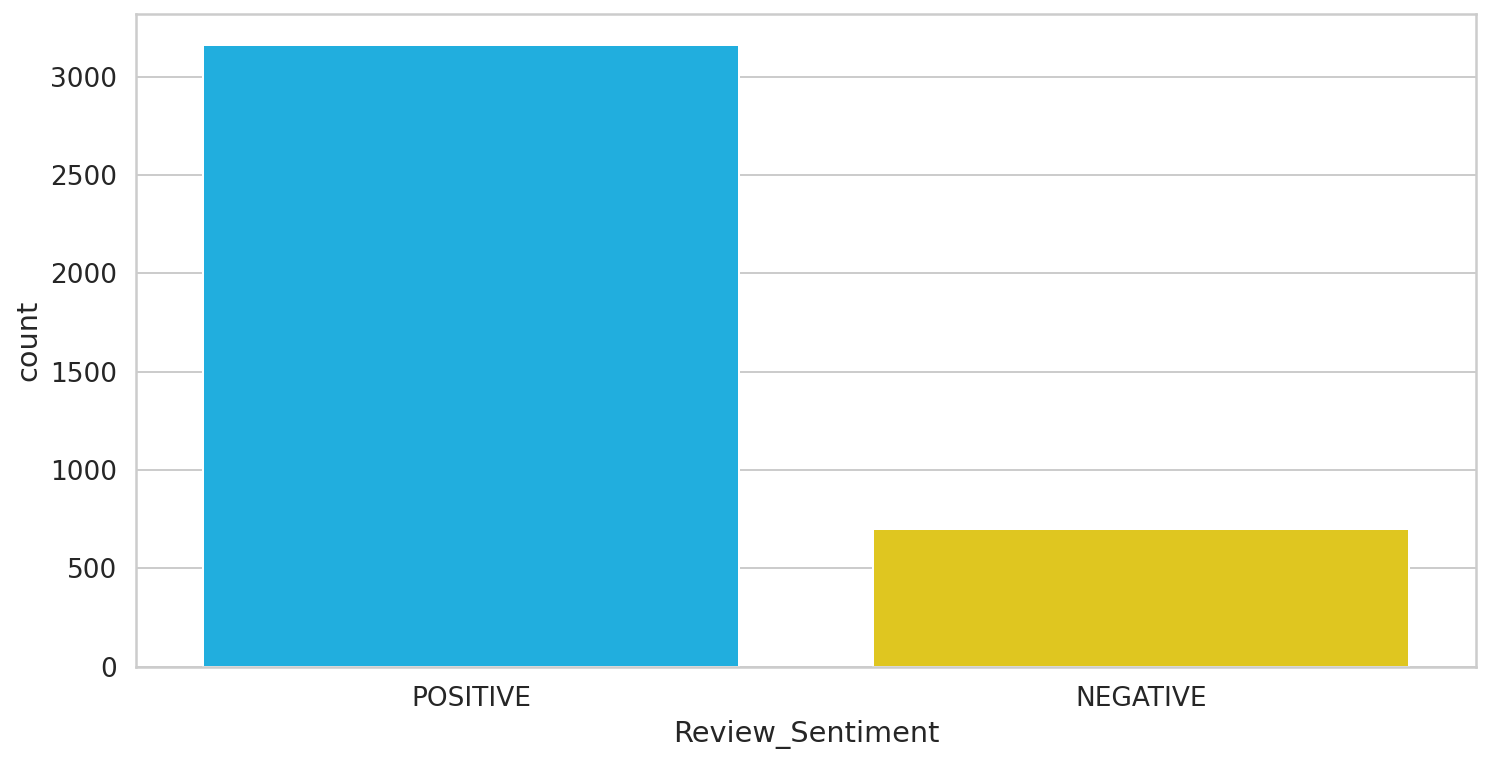

In [ ]:
sns.countplot(df.Review_Sentiment)
plt.xlabel('Review_Sentiment')

**Encode out text labels to numeric.**

In [ ]:
# Initiate LabelEncoder class
le =LabelEncoder()
# dataset
df['Review_Sentiment'] = le.fit_transform(df['Review_Sentiment'])
df.Review_Sentiment.value_counts()   # 0 -Negative, 1 - Positive

1    3159
0     702
Name: Review_Sentiment, dtype: int64

**Define pre-trained model**

Since our text data is lower cased, we are considering "**bert-base-uncased**" pre-trained model for our task.

In [ ]:
pre_trained_model='bert-base-uncased'

**Load the BERT tokenizer:**     
BertTokenizer will convert the raw text into numerical vectors i.e., input ids.

In [ ]:
tokenizer=BertTokenizer.from_pretrained(pre_trained_model)

**Split the dataset into train, validation, & test sets**

We will split dataset into train data (80 %) and validation data(10%), test data (10 %)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['review_preprocessed'],df.Review_Sentiment, test_size=0.2, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state = 42)

In [ ]:
# Convert to list
train_reviews = x_train.tolist()
val_reviews = x_val.tolist()
test_reviews = x_test.tolist()

In [ ]:
# Check train reviews
train_reviews[:10]

['i had the most precious meal at geek hq surrounded by all the super heroes i love.  this is a place that everyone can go and enjoy the meals. they are very unique and the dishes are amazingly delicious. very friendly and nice staff. 100%...recommending this place. it definitely will be a memorable experience in colombo.more',
 'we did book to go to the new years eve bash but the hotel lost our reservation, very common in sri lanka, but they were able to get us a seating in the restaurant 1864.  turned out, we had a fantastic meal.',
 'the atmosphere and ambience take you back to the colonial times. enjoy the view and the different cocktails with the fantastic team of waiters.',
 'we tried the sizzle twice in one week . as i believe you can t review a restaurant with one go.  the menu was confusing , but the stuarts make sure you understand it. on the first day they had some instagram person , and one...manager or someone didn t notice any of the other people and running behind this i

In [ ]:
# Create token ids (input ids) for each review
# Train dataset
train_input_ids = [tokenizer.encode(train_reviews[i],add_special_tokens = True) for i in range(0,len(train_reviews))]
# Val dataset
val_input_ids = [tokenizer.encode(val_reviews[i],add_special_tokens = True) for i in range(0,len(val_reviews))]
# Test dataset
test_input_ids = [tokenizer.encode(test_reviews[i],add_special_tokens = True) for i in range(0,len(test_reviews))]

###Padding & Truncating

Pad and truncate our sequences so that they all have the same length, Maximum explanation length.

In [ ]:
max_train_length = max([len(review) for review in train_input_ids])
max_val_length = max([len(review) for review in val_input_ids])
max_test_length = max([len(review) for review in test_input_ids])
                       
print('Max review length for train data: ', max_train_length)
print('Max review length for dev/validation data: ', max_val_length)
print('Max review length for test data: ', max_test_length)

Max review length for train data:  490
Max review length for dev/validation data:  456
Max review length for test data:  489


In [ ]:
from keras.preprocessing.sequence import pad_sequences    # Pad utility function to pad sequences to maximum length.
 
# Train dataset
Max_length = max_train_length
print('\nPadding/truncating all sentences to %d values for train dataset...' % Max_length)
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence
train_input_ids = pad_sequences(train_input_ids, maxlen=Max_length, dtype="long", 
                          value=0, truncating="post", padding="post")

# Validation dataset
Max_length = max_val_length   
print('\nPadding/truncating all sentences to %d values for val dataset...' % Max_length)
val_input_ids = pad_sequences(val_input_ids, maxlen=Max_length, dtype="long", 
                          value=0, truncating="post", padding="post")

# Test dataset
Max_length = max_test_length
print('\nPadding/truncating all sentences to %d values for test dataset' % Max_length)
test_input_ids = pad_sequences(test_input_ids, maxlen=Max_length, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\n All are done.')


Padding/truncating all sentences to 490 values for train dataset...

Padding/truncating all sentences to 456 values for val dataset...

Padding/truncating all sentences to 489 values for test dataset

 All are done.


##### Let's see how a revew looks before & after tokenization with padding.

In [ ]:
# Before tokenization
train_reviews[0]

'i had the most precious meal at geek hq surrounded by all the super heroes i love.  this is a place that everyone can go and enjoy the meals. they are very unique and the dishes are amazingly delicious. very friendly and nice staff. 100%...recommending this place. it definitely will be a memorable experience in colombo.more'

In [ ]:
# After tokenization
train_input_ids[0]

array([  101,  1045,  2018,  1996,  2087,  9062,  7954,  2012, 29294,
       16260,  5129,  2011,  2035,  1996,  3565,  7348,  1045,  2293,
        1012,  2023,  2003,  1037,  2173,  2008,  3071,  2064,  2175,
        1998,  5959,  1996, 12278,  1012,  2027,  2024,  2200,  4310,
        1998,  1996, 10447,  2024, 29350, 12090,  1012,  2200,  5379,
        1998,  3835,  3095,  1012,  2531,  1003,  1012,  1012,  1012,
       16755,  2075,  2023,  2173,  1012,  2009,  5791,  2097,  2022,
        1037, 13432,  3325,  1999, 16224,  1012,  2062,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

Tokens 101, & 102 represents the starting & ending of the sentence. Token 0 is the paddded token. All other tokens are encoded for each word in a sentence.

### Attention Masks

The attention mask simply makes it explicit which tokens are actual words versus which are padding.

In [ ]:
# Create attention masks

# Train dataset
train_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in train_input_ids]
# dev dataset
val_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in val_input_ids]
# Test dataset
test_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in test_input_ids]

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype for our model.

# input_ids
train_inputs = torch.tensor(train_input_ids)
val_inputs = torch.tensor(val_input_ids)
test_inputs = torch.tensor(test_input_ids)
# labels
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)
test_labels = torch.tensor(y_test.values)
# attention masks
train_masks = torch.tensor(train_attention_masks)
val_masks = torch.tensor(val_attention_masks)
test_masks = torch.tensor(test_attention_masks)

In [ ]:
# Create a DataLoader to load our datasets

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our val set.
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# Number of classes / labels
n_classes = y_train.nunique()
n_classes

2

## **Build a sentiment Classifier**

**BertForSequenceClassification**

We use the **BertForSequenceClassification** model for our classification task. It is a normal BERT with an added single layer on top of it for classification.

In [ ]:
model = BertForSequenceClassification.from_pretrained(pre_trained_model,num_labels = n_classes,
                                                          output_attentions = False,output_hidden_states = False )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Move model to the GPU

In [ ]:
model = model.to(device) 

### Optimizer & Learning Rate Scheduler

As per original paper on BERT, we will use [AdamW]('https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw') optimizer for correcting weight decay. We will also use, linear scheduler with no warm up steps:

In [ ]:
epochs=2
# Define optimizer for updating weights
optimizer=AdamW(model.parameters(),lr=3e-5)
total_steps=len(train_dataloader)*epochs

# Scheduler for learning rate change
scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
 # Define loss function & move it to GPU
loss_fn=nn.CrossEntropyLoss().to(device)

### Train our model

**Define a function for calculating elapsed time.**

In [ ]:
def format_time(elapsed):
    # Round to the nearest second
    elapsed_round = int(round(elapsed))
    # Format time in hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_round))

Define a function to calculate accuracy

In [ ]:
def accuracy(preds, labels):
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(preds == labels) / len(labels)

**Start training...**

In [ ]:
# Store loss value for each epoch
loss_values = []
acc_values = []
for epoch in range(0,epochs):
     
        # Perform forward pass over the training dataset
        print("\n ======== Epoch {:}/{:} ========".format(epoch+1,epochs))
        print('Training....')
        
        # Measure how long a epoch takes
        t0 = time.time()
        # Reset total loss  & acc for this epoch
        total_loss = 0
        total_acc = 0
        
        # Put the model in training mode
        model.train()
        
        # For each training batch
        for step, batch in enumerate(train_dataloader):
            # Update progress for 40 steps
            if (step % 40 ==0) & (not step==0):
                # Calculate elapsed time in minutes
                elapsed = format_time((time.time()-t0))
                # Report progress
                print(' Batch {:>5,} of {:>5,}. Elapsed:{:}.'.format(step,len(train_dataloader),elapsed))
            
            # Unpack training batch from trainloader & move to GPU
            b_input_ids = batch[0].to(device)  # 0 - input ids
            b_attention_mask = batch[1].to(device) # 1 - input masks
            b_labels = batch[2].to(device)     # 2 - labels
            
            # Clear default gradients accumulated in Pytorch
            model.zero_grad()
            
            # Output the results
            outputs = model(input_ids = b_input_ids, attention_mask = b_attention_mask, labels=b_labels) # Return tuple
            # Loss value from output
            loss = outputs.loss   # loss
            
            # Update total loss
            total_loss += loss.item()
            
            preds = outputs.logits  # Output probabilities
            # Move logits and labels to CPU
            preds = preds.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            tmp_train_accuracy = accuracy(preds, label_ids)

            # Accumulate the total accuracy.
            total_acc += tmp_train_accuracy
            
            # Perform a backward pass to calculate gradients
            loss.backward()
            
            # To avoid exploding vanishing gradients problem,clip the norm of the gradients to 1.0
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            
            # Update the parameters (weights)
            optimizer.step()
            
            # Update the learning rate
            scheduler.step()
            
        # Calculate the average loss over training data
        avg_total_loss = total_loss/len(train_dataloader)
            
        # Store the loss values
        loss_values.append(avg_total_loss)

        # Calculate the average loss over the training data.
        avg_train_acc = total_acc / len(train_dataloader)

        # Store the loss value for plotting the learning curve.
        acc_values.append(avg_train_acc)

        print("")
        print("\nAverage training accuracy: {0:.2f}".format(avg_train_acc))
        
        print('Average training loss : {0:.2f}'.format(avg_total_loss))
        print('Training epoch took: {:}'.format(format_time(time.time()- t0)))
        
        ####### Validation #######
        # After each epoch perform validation to check model performance
        print('\n Running validation...')
        
        t0 = time.time()
        #put model in evaluation mode
        model.eval()
        
        # Tracking variables
        eval_loss,eval_acc = 0,0
        nb_eval_steps,nb_eval_examples = 0,0
        
        # Evaluate val data for each epoch
        for batch in val_dataloader:
            # Move batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack inputs from dev dataloader
            b_input_ids, b_attention_mask, b_labels = batch
            # Tell model not to compute gradients to save memory & speed up validation
            with torch.no_grad():
                # Forward pass, calculate logit prediction
                outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
            # logits are class probabilities & get them from outputs
            logits = outputs[0]
            
            # Move logits & labels to CPU
            logits = logits.detach().cpu().numpy()
            labels = b_labels.to('cpu').numpy()
                
            # Calculate accuracy for this batch
            eval_accuracy = accuracy(logits,labels)
                
            # Accumulate total evaluation accuracy
            eval_acc += eval_accuracy
                
            # Track the number of steps
            nb_eval_steps += 1
                
        # Report the final validation accuracy
        print(' Accuracy {0:.2f}'.format(eval_acc/nb_eval_steps))
        print(' Validation took : {:}'.format(format_time(time.time() - t0)))
            
            
print('\n Training completed!')


 ======== Epoch 1/2 ========
Training....
 Batch    40 of   386. Elapsed:0:00:28.
 Batch    80 of   386. Elapsed:0:00:56.
 Batch   120 of   386. Elapsed:0:01:25.
 Batch   160 of   386. Elapsed:0:01:56.
 Batch   200 of   386. Elapsed:0:02:26.
 Batch   240 of   386. Elapsed:0:02:55.
 Batch   280 of   386. Elapsed:0:03:26.
 Batch   320 of   386. Elapsed:0:03:56.
 Batch   360 of   386. Elapsed:0:04:26.


Average training accuracy: 0.91
Average training loss : 0.24
Training epoch took: 0:04:46

 Running validation...
 Accuracy 0.93
 Validation took : 0:00:12

 ======== Epoch 2/2 ========
Training....
 Batch    40 of   386. Elapsed:0:00:30.
 Batch    80 of   386. Elapsed:0:01:00.
 Batch   120 of   386. Elapsed:0:01:30.
 Batch   160 of   386. Elapsed:0:02:00.
 Batch   200 of   386. Elapsed:0:02:31.
 Batch   240 of   386. Elapsed:0:03:01.
 Batch   280 of   386. Elapsed:0:03:31.
 Batch   320 of   386. Elapsed:0:04:01.
 Batch   360 of   386. Elapsed:0:04:31.


Average training accuracy: 0.98
Av

**Plot training loss & Accuracy vs Epoch**:

In [ ]:
df1 = pd.DataFrame(loss_values,columns=['Loss'])
df1['ACC'] = acc_values

In [ ]:
df1.index+=1

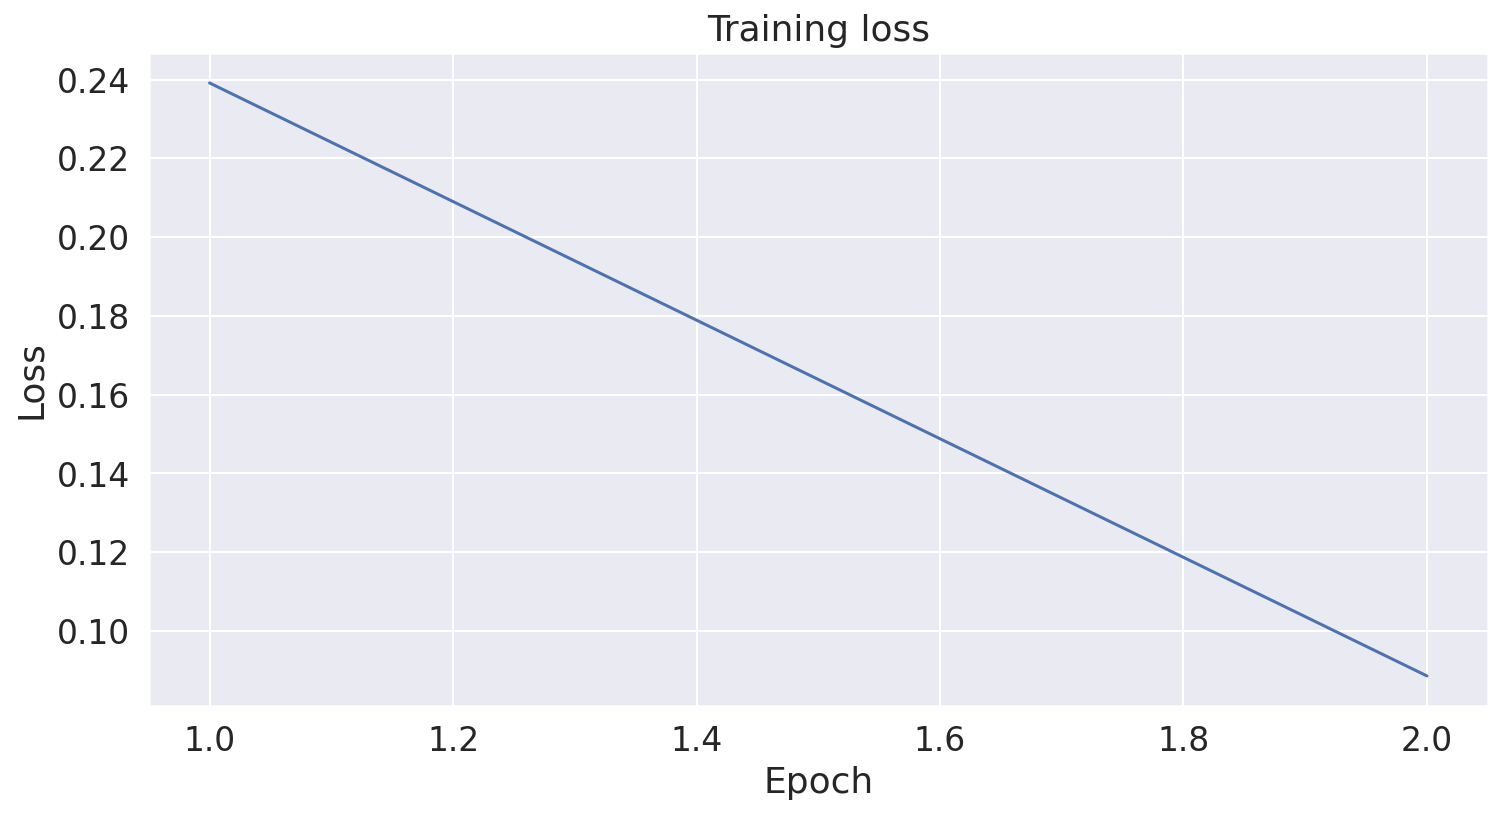

In [ ]:
# Plot training loss vs epochs
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
sns.lineplot(data=df1,x=df1.index,y=df1.Loss)

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

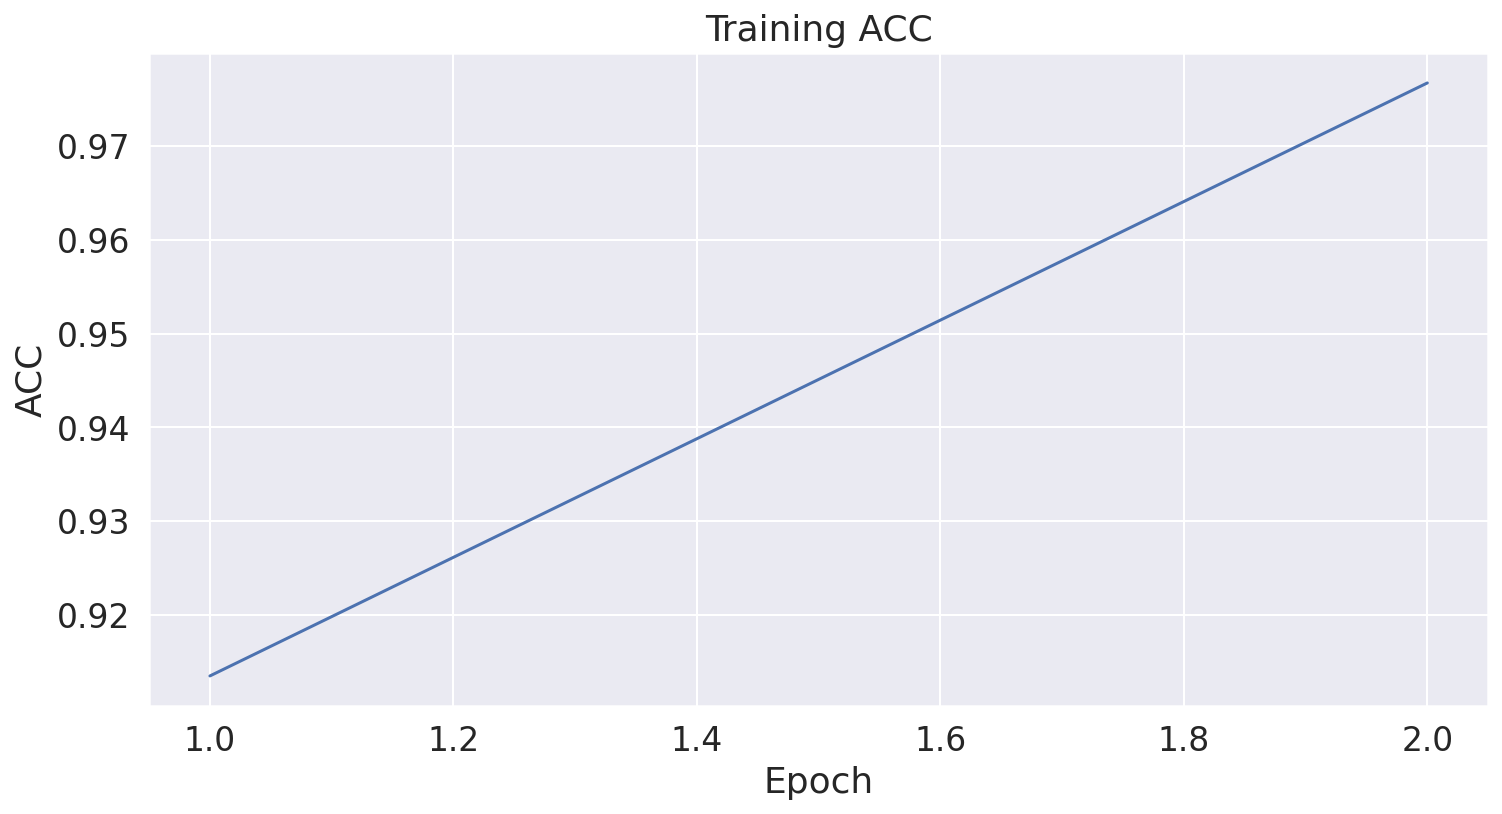

In [ ]:
# Plot training acc vs epochs
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
sns.lineplot(data=df1,x=df1.index,y=df1.ACC)

# Label the plot.
plt.title("Training ACC")
plt.xlabel("Epoch")
plt.ylabel("ACC")

plt.show()

In [ ]:
# Model performance on unseen data (test data)
print('\n Running testing on unseen data...')

#put model in evaluation model
model.eval()

# Tracking variables
# Tracking variables
predictions , true_labels = [], []

# Evaluate test data
for batch in test_dataloader:
    # Move batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack inputs from test dataloader
    b_input_ids,b_attention_mask,b_labels = batch
    # Tell model not to compute gradients to save memory & speed up validation
    with torch.no_grad():
        # Forward pass, calculate logit prediction
        outputs = model(input_ids=b_input_ids,attention_mask=b_attention_mask)
    # logits are class probabilities & get them from outputs
    logits = outputs[0]

    # Move logits & labels to CPU
    #logits = logits.detach().cpu().numpy()
    #labels = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.extend(logits.tolist())
    true_labels.extend(b_labels.tolist())

print('Done')


 Running testing on unseen data...
Done


In [ ]:
# Convert logits to tensor
preds = torch.tensor(predictions)

In [ ]:
import torch.nn.functional as F
# Apply Softmax on logits/preds
preds = F.softmax(preds,dim=1)

In [ ]:
# convert to numpy arrays
preds = np.array(preds)
true_labels = np.array(true_labels)

### Confusion matrix

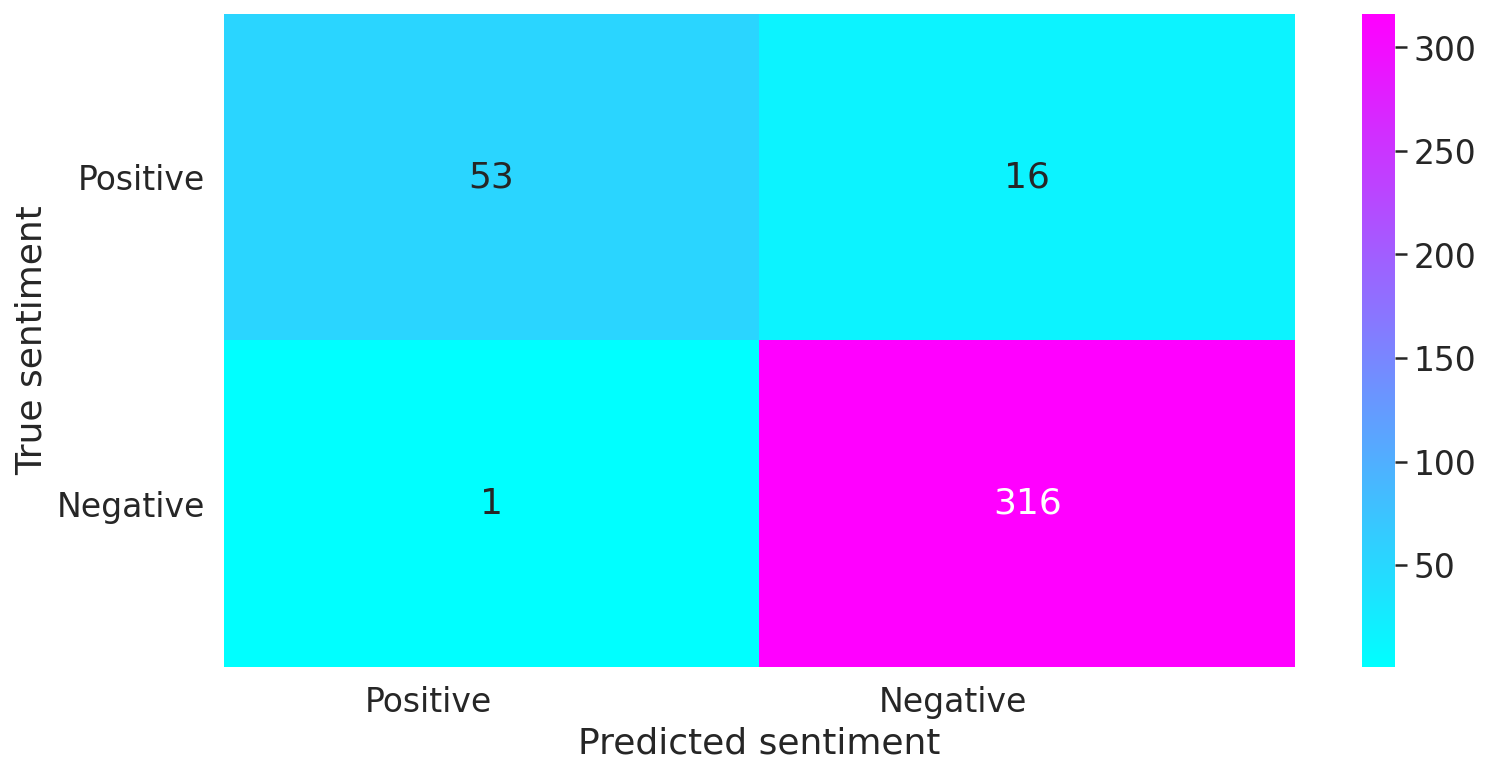

In [ ]:
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(12,6))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="cool")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(true_labels, preds.argmax(1))
class_names = ['Positive', 'Negative']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Classification Report

In [ ]:
class_report= classification_report(true_labels, preds.argmax(1))
print(class_report)

              precision    recall  f1-score   support

           0       0.98      0.77      0.86        69
           1       0.95      1.00      0.97       317

    accuracy                           0.96       386
   macro avg       0.97      0.88      0.92       386
weighted avg       0.96      0.96      0.95       386



### Plot PR (Precision-Recall) curve:

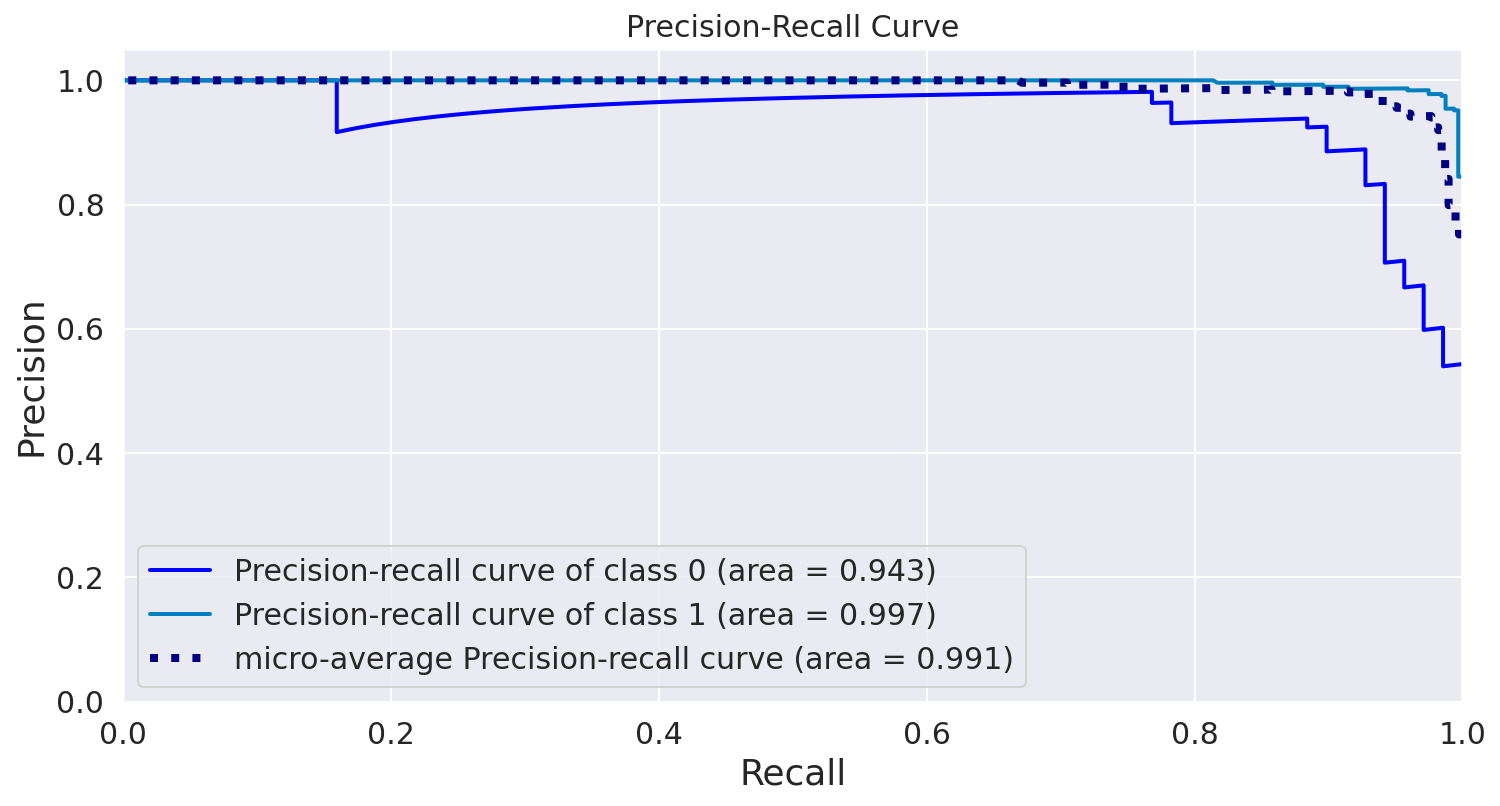

In [ ]:
# Plot PR curve
skplt.metrics.plot_precision_recall(true_labels, preds, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                                   cmap = 'winter')
plt.show()

### ROC (Receiver operating characterstic) curve:

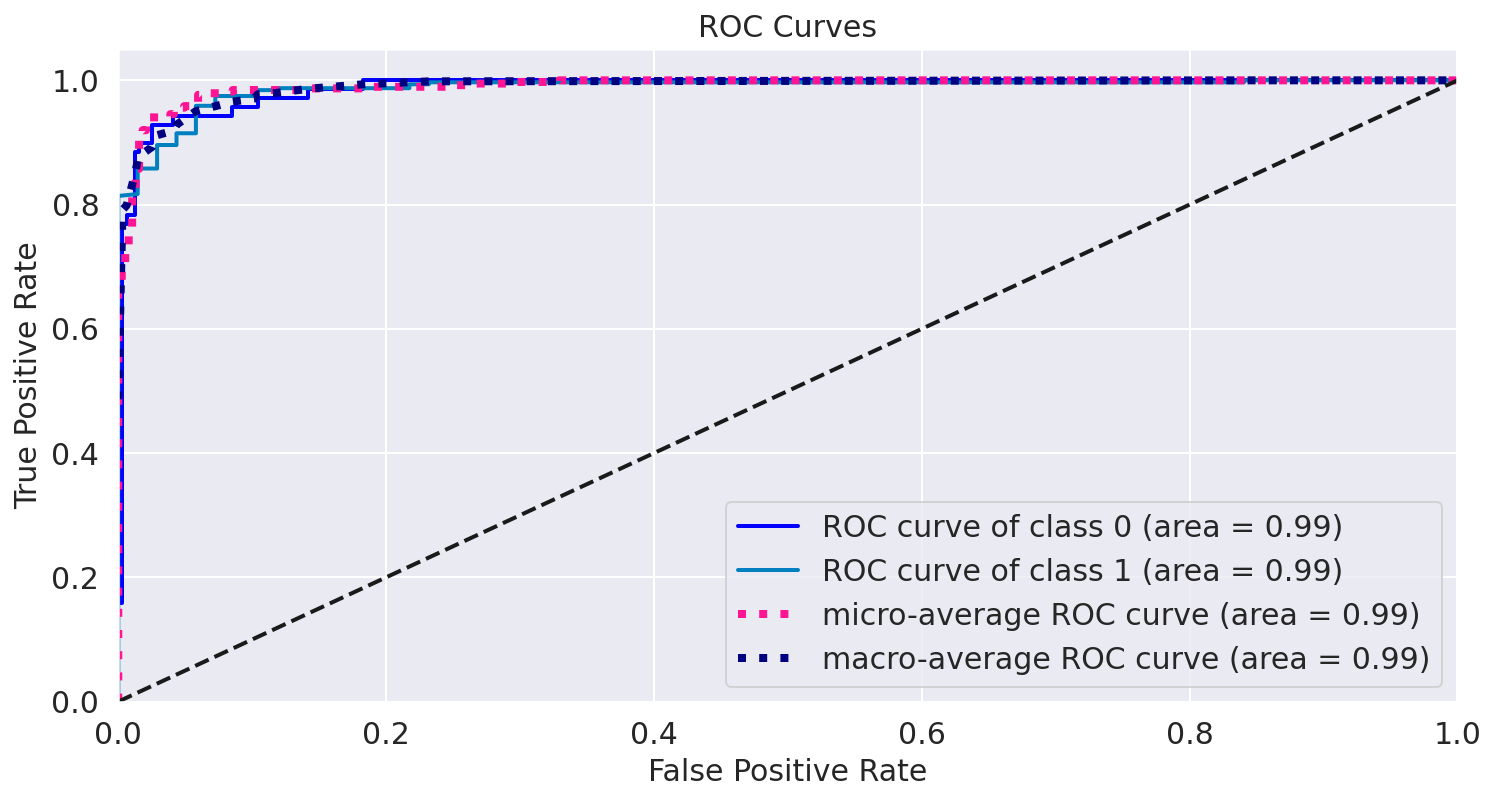

In [ ]:
# Plot ROC curve
skplt.metrics.plot_roc(true_labels, preds, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

We need the Sentiment scores for all restaurants to rank them from top to bottom. So, we are create a single dataloader for all restaurants & predict sentiment score for each.

In [ ]:
df_reviews = df['review_preprocessed'].tolist() 

NameError: ignored

In [ ]:
# Create token ids (input ids) for each review
input_ids = [tokenizer.encode(df_reviews[i],add_special_tokens = True) for i in range(0,len(df_reviews))]

Padding & Truncating:

In [ ]:
max_length = max([len(review) for review in input_ids])
                       
print('Max review length for whole data: ', max_length)

Max review length for whole data:  490


In [ ]:
Max_length = max_length
print('\nPadding/truncating all sentences to %d values for whole dataset...' % Max_length)
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence
input_ids = pad_sequences(input_ids, maxlen=Max_length, dtype="long", 
                          value=0, truncating="post", padding="post")
print('Done!')


Padding/truncating all sentences to 490 values for whole dataset...
Done!


In [ ]:
# Create attention mask
attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in input_ids]

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype for our model.

# input_ids
inputs = torch.tensor(input_ids)
# labels
labels = torch.tensor(df.Review_Sentiment.values)
# attention masks
att_masks = torch.tensor(attention_masks)

In [ ]:
# Create a DataLoader to load our datasets

batch_size = 8

# Create the DataLoader for our whole dataset.
data = TensorDataset(inputs, att_masks, labels)
sampler = RandomSampler(data)
dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

In [ ]:
# Model performance on whole data 
print('\n Running testing on whole data...')

#put model in evaluation model
model.eval()

# Tracking variables
preds , actual_labels = [], []

# Evaluate whole data
for batch in dataloader:
    # Move batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack inputs from test dataloader
    b_input_ids, b_attention_mask, b_labels = batch
    # Tell model not to compute gradients to save memory & speed up validation
    with torch.no_grad():
        # Forward pass, calculate logit prediction
        outputs = model(input_ids=b_input_ids,attention_mask=b_attention_mask)
    # logits are class probabilities & get them from outputs
    logits = outputs[0]
    
    # Store predictions and true labels
    preds.extend(logits.tolist())
    actual_labels.extend(b_labels.tolist())

print('Done')


 Running testing on whole data...
Done


In [ ]:
# Convert logits to tensor
preds = torch.tensor(preds)

In [ ]:
# Apply Softmax on logits/preds
preds = F.softmax(preds,dim=1)

In [ ]:
# convert to numpy arrays
preds = np.array(preds)

In [ ]:
df_final = df.drop('Review',axis=1)
df_final.head()

,Title,ReviewDate,Stay Date,Restaurant_Name,Review_Sentiment,review_preprocessed
0,b Highly recommended,"b Reviewed September 14, 2020",b Date of visit: September 2020,The Four Leafed Clover,1,we went for lunch. from very first their part ...
1,"b Excellent food, great ambience","b Reviewed September 5, 2020",b Date of visit: September 2020,The Four Leafed Clover,1,great service and delicious food. we had the l...
2,b Excellent Food and Place,"b Reviewed August 15, 2020",b Date of visit: August 2020,The Four Leafed Clover,1,"as i went, there were enough parking space, th..."
3,b Good Food and Ambience Food,"b Reviewed February 9, 2020",b Date of visit: February 2020,The Four Leafed Clover,1,good food and ambience food and ambience was...
4,b Loved everything about The Four Leafed Clover,"b Reviewed January 17, 2020",b Date of visit: January 2020,The Four Leafed Clover,1,excellent quiet and clean place for a relaxed ...


In [ ]:
df_final.shape

(3861, 6)

In [ ]:
df_pred = pd.DataFrame(preds, columns = ['Negative_score','Positive_score'])

In [ ]:
# Merge df_final & df_pred 
df_final = df_final.merge(df_pred, left_index=True, right_index=True)

In [ ]:
df_final

,Title,ReviewDate,Stay Date,Restaurant_Name,Review_Sentiment,review_preprocessed,Negative_score,Positive_score
0,b Highly recommended,"b Reviewed September 14, 2020",b Date of visit: September 2020,The Four Leafed Clover,1,we went for lunch. from very first their part ...,0.000348,0.999652
1,"b Excellent food, great ambience","b Reviewed September 5, 2020",b Date of visit: September 2020,The Four Leafed Clover,1,great service and delicious food. we had the l...,0.000397,0.999603
2,b Excellent Food and Place,"b Reviewed August 15, 2020",b Date of visit: August 2020,The Four Leafed Clover,1,"as i went, there were enough parking space, th...",0.998848,0.001152
3,b Good Food and Ambience Food,"b Reviewed February 9, 2020",b Date of visit: February 2020,The Four Leafed Clover,1,good food and ambience food and ambience was...,0.000776,0.999224
4,b Loved everything about The Four Leafed Clover,"b Reviewed January 17, 2020",b Date of visit: January 2020,The Four Leafed Clover,1,excellent quiet and clean place for a relaxed ...,0.000370,0.999630
...,...,...,...,...,...,...,...,...
3856,b \xf0\x9f\x8e\x82\xf0\x9f\x8e\x82,"b Reviewed July 11, 2020",b Date of visit: July 2020,Royal Thai - Cinnamon Lakeside,1,nice experience.. nice food.had a anniversary ...,0.000606,0.999394
3857,b Best Thai restaurant in Colombo,"b Reviewed July 7, 2020",b Date of visit: July 2020,Royal Thai - Cinnamon Lakeside,1,we visited the royal thai restaurant of cinnam...,0.000374,0.999626
3858,"b High quality food, nice presentation, lovel...","b Reviewed March 29, 2020",b Date of visit: March 2020,Royal Thai - Cinnamon Lakeside,1,due to the fact that all local restaurants wer...,0.000322,0.999678
3859,b Superb,"b Reviewed March 25, 2020",b Date of visit: March 2020,Royal Thai - Cinnamon Lakeside,1,we ate here on 5/3/20 whilst staying at the ci...,0.000375,0.999625


In [ ]:
df_final = df_final.drop(['review_preprocessed','Review_Sentiment'], axis=1)
df_group = df_final.groupby('Restaurant_Name').mean()

In [ ]:
df_group = df_group.sort_values(by = ['Positive_score'], ascending=False)

In [ ]:
df_group

,Negative_score,Positive_score
Restaurant_Name,,
Cafe993 Restaurant,0.000359,0.999641
Baked - Dessert & Coffee House,0.000359,0.999641
Caterina Pizzeria,0.000361,0.999639
The Sandwich Factory,0.000366,0.999634
Waves Bar & Restaurant,0.000369,0.999631
...,...,...
The Grove,0.499397,0.500603
Il Ponte,0.499622,0.500378
Hancook kitchen,0.499724,0.500276


In [ ]:
df_restaurant = df_group.reset_index(drop=False)

In [ ]:
df_restaurant

,Restaurant_Name,Negative_score,Positive_score
0,Cafe993 Restaurant,0.000359,0.999641
1,Baked - Dessert & Coffee House,0.000359,0.999641
2,Caterina Pizzeria,0.000361,0.999639
3,The Sandwich Factory,0.000366,0.999634
4,Waves Bar & Restaurant,0.000369,0.999631
...,...,...,...
434,The Grove,0.499397,0.500603
435,Il Ponte,0.499622,0.500378
436,Hancook kitchen,0.499724,0.500276
437,Flower Gate Chinese Restaurant,0.570600,0.429400


In [ ]:
df_restaurant = df_restaurant.rename(columns = {'Restaurant_Name':'Name'})

In [ ]:
df_restaurant

,Name,Negative_score,Positive_score
0,Cafe993 Restaurant,0.000359,0.999641
1,Baked - Dessert & Coffee House,0.000359,0.999641
2,Caterina Pizzeria,0.000361,0.999639
3,The Sandwich Factory,0.000366,0.999634
4,Waves Bar & Restaurant,0.000369,0.999631
...,...,...,...
434,The Grove,0.499397,0.500603
435,Il Ponte,0.499622,0.500378
436,Hancook kitchen,0.499724,0.500276
437,Flower Gate Chinese Restaurant,0.570600,0.429400


In [ ]:
df_restaurant.to_csv('Restaurants_with_sentiment_scores_BERT.csv', index=False)

### Performance comparision between SVM with BOW features & fine tuned BERT model.

In [ ]:
Results={
    'Model':['BOW SVM model','BERT model'],
    'f1-score(weighted)':[0.89, 0.95],                # f1-score is weighted average
    'AUC':[0.815, 0.99]                     # Calculated from ROC curve (AUC --> Area under ROC curve)
}

results_df=pd.DataFrame(Results)
results_df = results_df.sort_values(by = ['AUC'], ascending=False).reset_index(drop=True)
results_df.index+=1
results_df

,Model,f1-score(weighted),AUC
1,BERT model,0.95,0.990
2,BOW SVM model,0.89,0.815
